In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

2023-06-15 03:03:44.676347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 03:03:44.854959: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-15 03:03:45.499717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-15 03:03:45.499846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

# Params

In [2]:
image_size = (180, 180)
input_shape = (180, 180, 3)
batch_size = 32
n_cat=38

epochs = 1

# Import data

In [3]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
    validation_split=0.2,
    subset="both",
    seed=1234,
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Using 14059 files for validation.


2023-06-15 03:03:56.861728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 03:03:56.906602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 03:03:56.908454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 03:03:56.910902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
    label_mode="categorical",
    shuffle=False,
    image_size=image_size,
    batch_size=batch_size,
)

Found 17573 files belonging to 38 classes.


In [26]:
for i in test_ds.take(1):
    print(i)

(<tf.Tensor: shape=(32, 180, 180, 3), dtype=float32, numpy=
array([[[[ 23.900002 ,  19.844446 ,  39.9      ],
         [101.500374 ,  92.867035 , 118.76704  ],
         [101.95617  ,  92.95617  , 120.17839  ],
         ...,
         [167.85616  , 166.85616  , 197.85616  ],
         [167.15556  , 166.15556  , 197.15556  ],
         [168.57779  , 167.57779  , 198.57779  ]],

        [[ 23.900002 ,  19.844446 ,  39.9      ],
         [102.40111  ,  93.76778  , 119.66778  ],
         [102.598145 ,  93.598145 , 120.820366 ],
         ...,
         [166.51292  , 165.51292  , 196.51292  ],
         [165.50111  , 164.50111  , 195.50111  ],
         [166.52223  , 165.52223  , 196.52223  ]],

        [[ 24.111113 ,  20.055557 ,  40.111115 ],
         [102.96481  ,  94.33148  , 120.23148  ],
         [103.83333  ,  94.83333  , 122.05556  ],
         ...,
         [165.21909  , 164.21909  , 195.21909  ],
         [163.94444  , 162.94444  , 193.94444  ],
         [164.77716  , 163.77716  , 194.7771

# Model training

In [10]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

In [21]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(n_cat, 
                          activation="softmax")(x)

model = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_MobileNet")

In [22]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [24]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    steps_per_epoch=10,
                    validation_steps=10)

/opt/conda/lib/python3.7/site-packages/keras/backend.py:5532: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


10/10 [==============================] - 4s 305ms/step - loss: 5.6362 - categorical_accuracy: 0.0437 - accuracy: 0.0437 - val_loss: 3.9135 - val_categorical_accuracy: 0.0719 - val_accuracy: 0.0719


In [27]:
model.evaluate(test_ds)

 87/550 [===>..........................] - ETA: 48s - loss: 4.6314 - categorical_accuracy: 0.0101 - accuracy: 0.0101

KeyboardInterrupt: 

# Visualize data

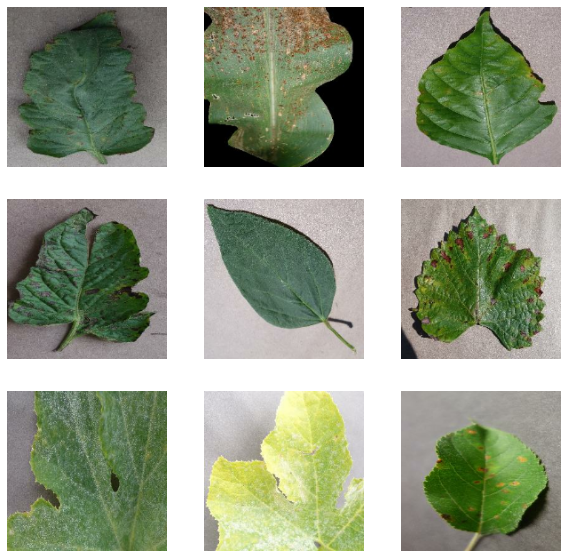

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(int(labels[i]))
        plt.axis("off")

# Model Prediction

In [73]:
# load model
model = tf.keras.models.load_model("20230612_01/plant_disease")

In [79]:
image_path = "dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Peach___healthy/06296d5e-8131-4d02-adbd-d6eed405c890___Rutg._HL 2437_180deg.JPG"
image = tf.keras.utils.load_img(image_path, target_size=image_size)

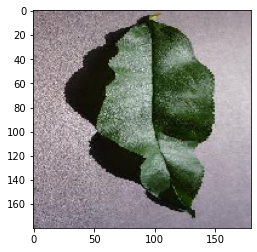

In [95]:
plt.imshow(image)

In [81]:
input_arr = tf.expand_dims(tf.keras.utils.img_to_array(image), axis=0)
input_arr.shape

TensorShape([1, 180, 180, 3])

In [82]:
prediction = model.predict(input_arr)
prediction

1/1 [==============================] - 0s 30ms/step


array([[1.9396368e-05, 5.4086330e-03, 5.7520426e-04, 6.4085899e-03,
        3.0679873e-03, 1.4463165e-04, 2.6890337e-05, 9.7770362e-07,
        5.5468513e-07, 1.6560614e-06, 7.5415880e-07, 1.5724760e-03,
        1.0809021e-03, 6.5724261e-04, 1.2593122e-02, 4.2875484e-04,
        3.8527202e-02, 3.5704726e-01, 4.3212133e-04, 2.4620122e-03,
        8.3283476e-06, 2.1156548e-02, 2.6088099e-05, 7.5032056e-04,
        6.2872618e-06, 6.3630609e-06, 8.0741438e-06, 1.1687967e-05,
        7.7164429e-04, 4.6240170e-02, 2.2136833e-01, 1.2530071e-03,
        1.2752451e-02, 1.5671615e-01, 5.3552490e-02, 2.3936359e-02,
        2.4967479e-02, 6.0119107e-03]], dtype=float32)

In [92]:
prediction_idx = np.argmax(prediction)

In [84]:
import json

In [89]:
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

In [93]:
class_indices[str(prediction_idx)]

'Peach___healthy'

In [ ]:
def predict(image_path,
            model,
            indices,
            image_size=(180, 180)):
    
    # load image
    image = tf.keras.utils.load_img(image_path, target_size=image_size)
    input_arr = tf.expand_dims(tf.keras.utils.img_to_array(image), axis=0)
    
    # predict image
    prediction = model.predict(input_arr)
    prediction_idx = np.argmax(prediction)
    
    # get the value
    return class_indices[str(prediction_idx)]